<a href="https://colab.research.google.com/github/programmingLover12/twitter/blob/main/twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [24]:
# 0 = non- rumor , 1 = rumor
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,LSTM,GRU,Bidirectional
# adding temporal cnn
#from tcn import TCN, tcn_full_summary
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
from  sklearn.model_selection import train_test_split
# adding temporal cnn
!pip install keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary
models_dir= "/content/drive/MyDrive/CSV_Files/Models"

In [25]:
def load_data(event,time=3600):
    events = ["charliehebdo", "ferguson", "germanwings-crash", "gurlitt", "ottawashooting", "putinmissing",
                "sydneysiege"]
    data = pd.read_csv(f'CSV_Files/{events[event]}.csv', names=['timeDiff', 'status', 'Freq'], header=0)
    
    data = data[data['timeDiff'] <= time]
    print(data)
    return data


In [26]:
def build_confusion_matrix(test,predict):

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in range(len(predict)):

        if test[i] == predict[i] == 1:
            TP = TP + 1
        elif test[i] == predict[i] == 0:
            TN = TN + 1
        elif test[i] != predict[i] and  predict[i] == 0:
            FN = FN + 1
        elif test[i] != predict[i] and  predict[i] == 1:
            FP = FP + 1

    return (TP,TN,FP,FN)


In [27]:
def split_train_test(training):
    scaler =  MinMaxScaler(feature_range=(0,1))
    training = scaler.fit_transform(training)
    train, test = train_test_split(training, test_size=0.3)
    return train, test


In [28]:
def build_tcnn(x_train,y_train,save, event_name,time,epoch=50):
    #!cd /content/drive/MyDrive/CSV_Files/Models
    seq = len(x_train)
    units = int((seq +2) / 2)
    look_back = 2

    model = Sequential() 
    model.add(TCN(units ,input_shape=(x_train.shape[1], look_back)) )
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics=["accuracy"])

    tcn_full_summary(model, expand_residual_blocks=False)
    model.fit(x_train, y_train, epochs=epoch)#, validation_split=0.2

    if save == True: 
        model.save(f'{models_dir}/TCNN/TCNN_{event_name}_{time}')
    return model


In [29]:

def build_LSTM(x_train,y_train,save,event_name,time,epoch=300):
    #,x_test, y_test
    seq = len(x_train)
    units = int((seq +2) / 2)
    look_back = 2
    model = Sequential()
    model.add(LSTM(units, input_shape = (x_train.shape[1], look_back)))
    model.add(Dense(1,activation='sigmoid'))
    model.compile( loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
    model.summary()
    model.fit(x_train, y_train, epochs=epoch, batch_size=32, verbose=2)
    
    if save == True: 
        model.save(f'{models_dir}/LSTM/LSTM_{event_name}_{time}')
    return model


In [30]:
def build_RNN(x_train,y_train,save,event_name,time,epoch=300):
    seq = len(x_train)
    units = int((seq +2) / 2)
    look_back =2

    model = Sequential()
    model.add(SimpleRNN(units, input_shape = (x_train.shape[1], look_back)))
    model.add(Dense(1,activation='sigmoid'))
    model.compile( loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
    model.summary()
    model.fit(x_train, y_train, epochs=epoch, batch_size=32, verbose=2)

    if save==True:        
        model.save(f'{models_dir}/SimpleRNN/SimpleRNN_{event_name}_{time}')
    return model


In [31]:
def build_GRU(x_train, y_train,save,event_name,time,epoch=300):
    seq = len(x_train)
    units = int((seq +2) / 2)
    look_back =2
    model = keras.Sequential()
    model.add(GRU(units, input_shape = (x_train.shape[1], look_back)))
    model.add(Dense(1,activation='sigmoid'))
    model.compile( loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
    model.summary()
    model.fit(x_train, y_train, epochs=epoch, batch_size=32, verbose=2)
    
    if save==True:
        model.save(f'{models_dir}/GRU/GRU_{event_name}_{time}')
    return model


In [32]:
def build_bi_LSTM(x_train, y_train,save,event_name,time,epoch=300):
    seq = len(x_train)
    units = int((seq +2) / 2)
    look_back =2
    
    
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units),input_shape = (x_train.shape[1], look_back) ))
    model.add(Dense(1,activation='sigmoid'))
    model.compile( loss='mean_squared_error', optimizer='adam',metrics=["accuracy"])
    model.summary()

    model.fit(x_train, y_train, epochs=epoch, batch_size=32, verbose=2)
    
    if save==True:
        model.save(f'{models_dir}/BiLSTM/BiLSTM_{event_name}_{time}')
    return model


In [33]:
def Build_Simple_Dense(x_train, y_train,save,event_name,time,epoch=300):
    seq = len(x_train)
    units = int((seq +2) / 2)
    look_back =2
    
    model = Sequential()
    model.add(Dense(units,input_shape = (x_train.shape[1], look_back)))
    model.add(Dense(1,activation='sigmoid'))
    model.compile( loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
    model.summary()
    model.fit(x_train, y_train, epochs=epoch, batch_size=32, verbose=2)
    
    if save==True:
        model.save(f'{models_dir}/Simple_Dense/Simple_Dense_{event_name}_{time}')
    return model

In [34]:
def load_models(event_name,time):
    # loading mdoel
    models = []
    models.append(keras.models.load_model(f'{models_dir}/LSTM/LSTM_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/SimpleRNN/SimpleRNN_{event_name}_{time}') )
    models.append(keras.models.load_model(f'{models_dir}/GRU/GRU_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/BiLSTM/BiLSTM_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/TCNN/TCNN_{event_name}_{time}'))
    return models


In [35]:
def load_implementaion_A(event_name,time):
    models = []
    models.append(keras.models.load_model(f'{models_dir}/LSTM/LSTM_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/SimpleRNN/SimpleRNN_{event_name}_{time}') )
    models.append(keras.models.load_model(f'{models_dir}/GRU/GRU_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/BiLSTM/BiLSTM_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/TCNN/TCNN_{event_name}_{time}'))
    
    x_test,y_test,_,_ = pre_process(event_name,time)
    return models,x_test,y_test




def load_implementaion_B(event_name,time):
    models = []
    models.append(keras.models.load_model(f'{models_dir}/LSTM/LSTM_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/SimpleRNN/SimpleRNN_{event_name}_{time}') )
    models.append(keras.models.load_model(f'{models_dir}/GRU/GRU_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/BiLSTM/BiLSTM_{event_name}_{time}'))
    models.append(keras.models.load_model(f'{models_dir}/Simple_Dense/Simple_Dense_{event_name}_{time}'))
    
    x_test,y_test,_,_ = pre_process(event_name,time)
    return models,x_test,y_test


In [36]:
def Ensembler_1(event_name,time,method):
    
    if time >600:
      print("ERROR : time stamp given greater than 600")
      return false
    
    
    array = None
    for model in models:
        if array is None:
            array = model.predict(x_test)
        else:
            a = model.predict(x_test)
            array = np.append(array,a, axis=1)
    
    result = []
    
    if method == 'vote':
    
      for row in iter(array):
          if (row > 0.50).sum() >=3:
              result.append(1)
          else:
              result.append(0)
    
    elif method == 'avg':
    
      for row in iter(array):
          avg = (row[0]+row[1]+row[2]+row[3]+row[4])/5
          
          if avg > 0.5:
            result.append(1)
          
          else:
            result.append(0)
              
    return np.array(result),expected


In [37]:
def pre_process(EVENT,TIME):
    data = load_data(event = EVENT, time=TIME)
    
    # splitted into 70 - 30
    train, test = train_test_split(data, test_size=0.3)
    
    x_train = train.drop(columns=["status"])
    y_train = train["status"] 

    scaler =  MinMaxScaler(feature_range=(0,1))
    x_train = scaler.fit_transform(x_train)


    x_test = test.drop(columns=["status"])
    y_test = test["status"] 

    scaler =  MinMaxScaler(feature_range=(0,1))
    x_test = scaler.fit_transform(x_test)

    #pdb.set_trace()

    # reshaping
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    return x_test,y_test,x_train,y_train


In [38]:
def predict(model,event,time):
  x_test,y_test,x_train,y_train = pre_process(event,time)
  m = keras.models.load_model(f'{models_dir}/{model}/{model}_{event}_{time}')
  result = m.predict(x_test)
  predicted = []
  for i,j in zip(result,y_test):
    if i > 0.500:
      #v=1
      predicted.append(1)
    else:
      #v=0
      predicted.append(0)

  return y_test,np.array(predicted)

In [39]:
def write_results(line):
  import csv
  with open(f'{models_dir}/individual_model_results.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.write(line)
    
  

In [41]:
def conclude_individual_results():
  import csv
  with open(f'{models_dir}/individual_model_results.csv', 'a',newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Model name','Event name','Time ','accuracy','precision','recall','f1_score','TP','TN','FP','FN'])
  
  
  events = [0,1,2,3,4,5,6]
  time = [120,300,600,1800,3600]
  models = ['SimpleRNN','LSTM','BiLSTM','GRU','Simple_Dense']
  events_names = ["charliehebdo", "ferguson", "germanwings-crash", "gurlitt", "ottawashooting", "putinmissing",
                "sydneysiege"]
  for m in models:
    for e in events:
      time_acc=[]
      for t in time:
        avg_acc=0
        avg_prec=0
        avg_recall=0
        avg_f1 =0
        for i in range(0,3):
          expected,predicted = predict(m,e,t)
          print(list(predicted),'  ',list(expected))
          TP,TN,FP,FN = build_confusion_matrix(list(expected),list(predicted))
          print('TP= ',TP,'  TN =',TN,'  FP= ',FP,' FN= ',FN)
          try:
            accuracy = (TN+TP) /(TN+TP+FN+FP)
            precision = TP / (TP+FP)
            recall = TP /(TP+FN)
            f1_score = 2*((precision * recall)/(precision + recall))
          except Exception:
            print('ERROR DIVISION BY ZERO')
            TP,TN,FP,FN =-1,-1,-1,-1  

          avg_acc +=accuracy
          avg_f1+=f1_score
          avg_recall+=recall
          avg_prec+=precision
          import csv
          with open(f'{models_dir}/individual_model_results.csv', 'a',newline='') as file:
            writer = csv.writer(file)
            writer.writerow([m,events_names[e],t,accuracy,precision,recall,f1_score,TP,TN,FP,FN])          
          
          print('accuracy = ',accuracy)
          print('precision = ',precision)
          print('recall = ',recall)
          print('f1 score = ',f1_score)
        import csv
        with open(f'{models_dir}/individual_model_results.csv', 'a') as file:
          writer = csv.writer(file)
          writer.writerow(['average accuracy','average F1 score','average recall','average precision'])
          writer.writerow([(avg_acc/3),(avg_f1/3),(avg_recall/3),(avg_prec/3)])
          time_acc.append((avg_acc/3))
    
      print('sfdsd')
      import csv
      with open(f'{models_dir}/summary_accuracy.csv', 'a',newline='') as file:
        writer = csv.writer(file)
        writer.writerow([m,events_names[e]])
        writer.writerow(time)
        writer.writerow(time_acc)
  

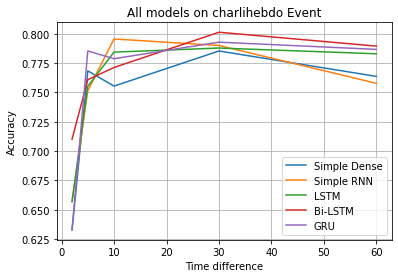

In [47]:
if __name__ == "__main__":
  #predicted,expected = Ensembler_1(0,120,'avg')
  #print(result)
  #print(list(predicted),'  ',list(expected))
  
  #SimpleRNN  LSTM  GRU BiLSTM TCNN
  #train on 45 min
  #draw graph which show which model outperformed all
  #
  #conclude_individual_results()
  
  #Simple Dense
  time = [2,5,10,30,60]
  #acc = 
  import matplotlib.pyplot as plt
  plt.plot(time,[0.632850242,0.768361582,0.755368814,0.785289515,0.763630428], label='Simple Dense')
  plt.plot(time,[0.657004831,	0.751412429	,0.795518207	,0.789984351,0.757753836], label='Simple RNN')
  plt.plot(time,[0.657004831,	0.755178908	,0.784313725	,0.787793427	,0.782892589], label='LSTM')
  plt.plot(time,[0.710144928,	0.760828625,	0.77124183	,0.801251956	,0.789422135], label='Bi-LSTM')
  plt.plot(time,[0.632850242,	0.785310734,	0.778711485	,0.792801252,	0.786647078], label='GRU')
  
  x_axis = 'time stamp'
  y_axis = 'accuracy'
  plt.xlabel('Time difference')
  plt.ylabel('Accuracy')
  plt.title('All models on charlihebdo Event')
  plt.grid(True)
  plt.legend()



  

In [ ]:
'''x_test,y_test,x_train,y_train = pre_process(4,600)
    model5_A = build_tcnn(x_train,y_train,SAVE_MODEL_AFTER_TRAINING ,4,600 ,120)
    for e in event:
      for t in time:
        x_test,y_test,x_train,y_train = pre_process(e,t)  
        if t== 1800 or t == 3600:
          epoch = 120
        else:
          epoch=300  
        epoch = 120
        #model1 = build_LSTM(x_train,y_train,SAVE_MODEL_AFTER_TRAINING    ,e,t  ,epoch)
        #model2 = build_GRU(x_train,y_train,SAVE_MODEL_AFTER_TRAINING ,e,t ,epoch)
        #model3 = build_bi_LSTM(x_train,y_train,SAVE_MODEL_AFTER_TRAINING ,e,t ,epoch)
        #model4 = build_RNN(x_train,y_train,SAVE_MODEL_AFTER_TRAINING ,e,t ,epoch)
        #Build_Simple_Dense(x_train,y_train,SAVE_MODEL_AFTER_TRAINING ,e,t ,epoch)    
        #model5_A = build_tcnn(x_train,y_train,SAVE_MODEL_AFTER_TRAINING ,e,t ,epoch)    
    '''


In [ ]:
'''
    # JUST CHANGE PARAMETERS HERE
    # charliehebdo=0, ferguson=1, germanwings-crash=2, gurlitt=3, ottawashooting=4, putinmissing=5,sydneysiege=6

    #=====================
    EVENT = 6
    # in seconds  120,300,600,1800,3600
    TIME = 120
    t=[120,300,600,1800,3600]
    e = [1,2,3,4,5,6]
    RUN_FROM_SAVED_MODELS = False#True
    
    SAVE_MODEL_AFTER_TRAINING=True
        #["charliehebdo", "ferguson", "germanwings-crash", "gurlitt", "ottawashooting", "putinmissing","sydneysiege"]
    # time in seocnds
    
    data = load_data(event = EVENT, time=TIME)
    
    # splitted into 70 - 30
    train, test = train_test_split(data, test_size=0.3)
    
    x_train = train.drop(columns=["status"])
    y_train = train["status"] 

    scaler =  MinMaxScaler(feature_range=(0,1))
    x_train = scaler.fit_transform(x_train)


    x_test = test.drop(columns=["status"])
    y_test = test["status"] 

    scaler =  MinMaxScaler(feature_range=(0,1))
    x_test = scaler.fit_transform(x_test)

    #pdb.set_trace()

    # reshaping
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    # Running and Saving Models
    #model1 = build_LSTM(x_train,y_train,SAVE_MODEL_AFTER_TRAINING    ,EVENT,TIME,60 )
    #model2 = build_GRU(x_train,y_train,SAVE_MODEL_AFTER_TRAINING     ,EVENT,TIME  ,60)
    #model3 = build_bi_LSTM(x_train,y_train,SAVE_MODEL_AFTER_TRAINING ,EVENT,TIME  ,60)
    #model4 = build_RNN(x_train,y_train,SAVE_MODEL_AFTER_TRAINING     ,EVENT,TIME  ,60)    
    #model5_A = build_tcnn(x_train,y_train,SAVE_MODEL_AFTER_TRAINING    ,EVENT,TIME  ,60)
    
    for eve in e:
      for i in t:
        model2 = build_GRU(x_train,y_train,SAVE_MODEL_AFTER_TRAINING     ,eve,i  ,300)
        model3 = build_bi_LSTM(x_train,y_train,SAVE_MODEL_AFTER_TRAINING ,eve,i  ,300)
        model4 = build_RNN(x_train,y_train,SAVE_MODEL_AFTER_TRAINING     ,eve,i  ,300)    
    



    #
    #if RUN_FROM_SAVED_MODELS == True:
    #    models = load_models(EVENT,TIME)
    #
    #else: # use above build models 
    #    models = []
    #    models.append(model1)
    #    models.append(model2)
    #    models.append(model3)
    #    models.append(model4)
    #    #models.append(model5)
    #result =  Ensembler_result(models,x_test)
    #r = (result == y_test).sum()
    #acc = r/len(y_test)
    #
    #print(result)
    #print(acc)

    #TP,TN,FP,FN = build_confusion_matrix(y_test,result)
    #
    #accuracy = (TN+TP) /(TN+TP+FN+FP)
    #precision = TP / (TP+FP)
    #recall = TP /(TP+FN)
    #f1_score = 2*((precision * recall)/(precision + recall))
    #print('accuracy = ',accuracy)
    #print('precision = ',precision)
    #print('recall = ',recall)
    #print('f1 score = ',f1_score)
    '''